#Forêts aléatoires
Dans ce TP, nous utiliserons les méthodes d'*ensemble learning* (*bagging* et *boosting*)



## Ensemble learning

L'idée est de combiner plusieurs modèles pour en faire un ensemble plus performants.

En général, on distingue deux familles de méthodes de ce type :

1. Méthodes par moyennage (*bagging*, forêts aléatoires) où le principe est de faire la moyenne de plusieurs prédictions .  
1. Méthodes adaptatives (*boosting*) où les paramètres sont itérativement adaptés pour produire un meilleur mélange.  


Dans la suite nous explorerons chacune de ces classes d’algorithme.

## *Bagging*

Les méthodes de type *bagging* construisent plusieurs instances d’un estimateur, calculées sur des échantillons aléatoires tirés de la base d’apprentissage. On réalise ensuite la moyenne des estimations pour réduire la variance de l'estimateur. 
Dans Scikit-learn, les méthodes de *bagging* sont implémentées via la classe `BaggingClassifier` et `BaggingRegressor`. Les constructeurs prennent en paramètres un estimateur de base et la stratégie de sélection des points et des *features* :

> - `base_estimator` : optionnel (default=None). Si None alors l’estimateur est un arbre de décision.  
- `max_samples` : la taille de l’échantillon aléatoire tiré de la base d’apprentissage.  
- `max_features` : le nombre de *features* tirés aléatoirement.  
- `bootstrap` : boolean, optionnel (default=True). Tirage des points avec remise ou non.  
- `bootstrap_features` : boolean, optionnel (default=False). Tirage des *features* avec remise ou non.  
- `oob_score` : boolean. Estimer ou non l’erreur de généralisation OOB (*Out of Bag*).  

Le code suivant construit un ensemble des classifieurs. Chaque classifieur de base est un `KNeighborsClassifier` (c’est-à-dire k-plus-proches-voisins), chacun utilisant au maximum 50% des points pour son apprentissage et la moitié des *features* :

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

Dans cet exemple nous allons utiliser la base de données `digits`, qui contient 10 classes (images des chiffres en écriture manuscrite). Il y a 1797 éléments, chaque élément a 64 attributs (8 pixels par 8).

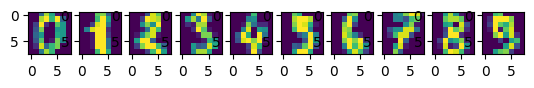

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

# Affichage des 10 premières images
import matplotlib.pyplot as plt
fig = plt.figure()
for i, digit in enumerate(digits.images[:10]):
    fig.add_subplot(1,10,i+1)
    plt.imshow(digit)
plt.show()

Pour établir des performances de référence, nous allons implémenter un arbre de décision pour la classification dans un premier temps sans découper la base d'apprentissage.

In [ ]:
# Correction
import numpy as np
from sklearn import tree
from sklearn.ensemble import BaggingClassifier

X, y = digits.data, digits.target
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)
accuracy = clf.score(X,y)
print(accuracy)

1.0


Sur la base d’apprentissage `accuracy = 1` . Découpons à présent la base de données en un jeu d’apprentissage et un jeux de test afin d'étudier la généralisation de l’arbre sur des données différentes de celles d’apprentissage :

In [ ]:
# Correction
from sklearn.model_selection import train_test_split
# 90% des données pour le test, 10% pour l'apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

Z = clf.predict(X_test)
accuracy = clf.score(X_test,y_test)
print(accuracy)

0.6891223733003708


Quelle sont la moyenne et la variance de la valeur `accuracy` sur 100 tirages pour la séparation apprentissage/test. Que pouvons-nous conclure ?

In [ ]:
N = 100
accuracies = []
for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    Z = clf.predict(X_test)
    accuracies.append(clf.score(X_test,y_test))
    print(accuracies[i])
# Correction
print(np.mean(accuracies), np.std(accuracies))

Pour comparer, construisons maintenant avec la méthode `BaggingClassifier` un classifieur *bagging* sur nos données, toujours basé sur les `DecisionTreeClassifier` :

In [ ]:
# Correction
clf = BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5, n_estimators=200)

L’apprentissage et l’évaluation de cet ensemble se font de la façon habituelle :

In [ ]:
# Correction
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
accuracy=clf.score(X_test,y_test)

Calculer la variance de la valeur `accuracy` sur 100 tirages pour la séparation apprentissage/test. Comparer avec la variance du classifieur de base. Que pouvons-nous conclure ?

On obtient un meilleur classifieur (`accuracy` ~ 97%), qui en plus est beaucoup plus stable : `stdev` autour de 1%.

Construire le graphique `accuracy` vs `n_estimators`. Que constatez-vous ?

Le taux d’erreur diminue avec `n_estimators`, mais à partir d’une valeur il se stabilise, donc on ne gagne rien à partir de cette valeur de `n_estimators`, si ce n’est que l’algorithme devient plus lent. Dans le code suivant nous avons pris `test_size = 0.5` pour que l’effet soit plus visible.

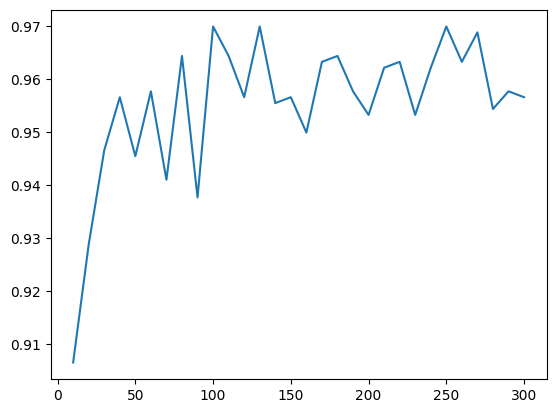

In [ ]:
N = 30
accuracy = []
# Correction
for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    clf = BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5, n_estimators=(i+1)*10)
    clf.fit(X_train, y_train)
    Z = clf.predict(X_test)
    accuracy.append(clf.score(X_test,y_test))

import matplotlib.pyplot as plt
plt.plot([10*(i+1) for i in range(N)], accuracy)
plt.show()

<img src="_images/tpforetsfig1.svg" style="width:100%;">

Faites varier les parametres `max_samples` et `max_features`. Pour quelles valeurs on obtient le meilleur résultat ? On pourra notamment utiliser `GridSearchCV` pour réaliser une recherche systématique.

Pour chercher des bonnes valeurs pour les paramètres on utilise la validation croisée avec `GridSearchCV`

In [ ]:
digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

from sklearn.model_selection import GridSearchCV
pgrid = {"max_samples": [0.2, 0.4, 0.6, 0.8],
        "max_features": [0.2, 0.4, 0.6, 0.8]}
# Correction
grid_search = GridSearchCV(BaggingClassifier(tree.DecisionTreeClassifier()), param_grid=pgrid, cv=5)
grid_search.fit(X_train, y_train)
print("Meilleur score : " + str(grid_search.best_estimator_.score(X_test, y_test)))
print("max_samples: " + str(grid_search.best_estimator_.max_samples))
print("max_features: " + str(grid_search.best_estimator_.max_features))

Meilleur score : 0.9254727474972191
max_samples: 0.6
max_features: 0.6


Le programme affiche (vos résultats seront légèrement différents) un score de 93% obtenu pour `max_samples = 0.8` et `max_features = 0.6`.

## Forêts aléatoires

L’algorithme des forêts aléatoires propose une optimisation des arbres de décision. Il utilise le même principe que le *bagging*, mais avec une étape supplémentaire de randomisation dans la sélection des attributs des nœuds dans le but de réduire la variance de l’estimateur obtenu. Les deux objets Python qui implémentent les forêts aléatoires sont `RandomForestClassifier` et `RandomForestRegressor`. Les paramètres les plus importants sont :

> - `n_estimators` : integer, optional (default=10). Le nombre d’arbres.  
- `max_features` : le nombre d’attributs à considérer à chaque split.  
- `max_samples` : la taille de l’échantillon aléatoire tiré de la base d’apprentissage.  
- `min_samples_leaf` : le nombre minimal d’éléments dans un nœud feuille.  
- `oob_score` : boolean. Estimer ou non l’erreur de généralisation OOB (*Out of Bag*).  



Par la suite nous allons refaire la classification sur la base Digits en utilisant un classifieur `RandomForestClassifier`. Comme d’habitude, on sépare les données en gardant 10% pour l’apprentissage et 90% pour le test.

In [ ]:
digits = load_digits()
X, y = digits.data, digits.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)

On peut désormais créer et entraîner notre modèle :

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

Puis réaliser les prédictions et calculer le score de test :

In [ ]:
# Correction
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test,y_test)
print(accuracy)

0.8912237330037083


Comment la valeur de la variable `accuracy` se compare avec le cas *bagging* qui utilise le même nombre d’arbres (200 dans notre cas) ?

In [ ]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
print("Arbre de décision : " + str(clf.score(X_test,y_test)))

clf = BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5, n_estimators=200)
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
print("Bagging (200 arbres) : " + str(clf.score(X_test,y_test)))

clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
print("Forêt aléatoire (200 arbres) : " + str(clf.score(X_test,y_test)))

Arbre de décision : 0.6946847960444994
Bagging (200 arbres) : 0.8702101359703337
Forêt aléatoire (200 arbres) : 0.8800988875154512


Les forêts aléatoires produisent un classifieur un peu meilleur sur cette base de données.

Construire la variance de la valeur `accuracy` sur 100 tirages pour la séparation apprentissage/test. Que pouvons-nous conclure en comparant avec la séction précedente (*bagging*) ?

In [ ]:
N = 10

bagging_accuracies = []
for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    clf = BaggingClassifier(tree.DecisionTreeClassifier(), n_estimators=30)
    clf.fit(X_train, y_train)
    bagging_accuracies.append(clf.score(X_test,y_test))

print(np.mean(bagging_accuracies), np.std(bagging_accuracies))


rf_accuracies = []
for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    clf = RandomForestClassifier(n_estimators=30)
    clf.fit(X_train, y_train)
    rf_accuracies.append(clf.score(X_test,y_test))

print(np.mean(rf_accuracies), np.std(rf_accuracies))

0.9353726362625139 0.013645646907721746
0.9592880978865406 0.008831783422148699


Nous avons donc non seulement un plus faible taux moyen d’erreurs, mais aussi une variance plus faible.

Construire le graphique `accuracy` vs `n_estimators`. Que constatez-vous ? A partir de quelle valeur on n’améliore plus ?

10 0.9332591768631813
20 0.9655172413793104
30 0.9688542825361512
40 0.9699666295884316
50 0.9744160177975528
60 0.9710789766407119
70 0.9744160177975528
80 0.9744160177975528
90 0.967741935483871
100 0.9721913236929922
110 0.9710789766407119
120 0.9710789766407119
130 0.9710789766407119
140 0.9744160177975528
150 0.9699666295884316
160 0.9710789766407119
170 0.9699666295884316
180 0.9744160177975528
190 0.978865406006674
200 0.9733036707452726
210 0.9744160177975528
220 0.9733036707452726
230 0.9721913236929922
240 0.9721913236929922
250 0.9744160177975528
260 0.9733036707452726
270 0.9744160177975528
280 0.9744160177975528
290 0.9721913236929922
300 0.9721913236929922


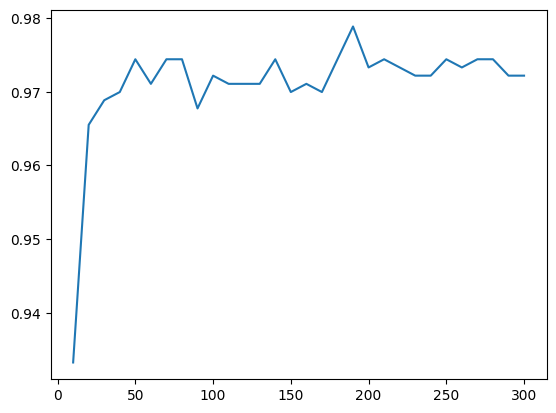

In [ ]:
N = 30
accuracy = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

for i in range(N):
    clf = RandomForestClassifier(n_estimators=(i+1)*10)
    clf.fit(X_train, y_train)
    accuracy.append(clf.score(X_test,y_test))
    print((i+1)*10, accuracy[i])

plt.plot([10*(i+1) for i in range(30)], accuracy)
plt.show()

<img src="_images/tpforetsfig2.svg" style="width:100%;">

  
A partir de `n_estimators = 50` le résultat commence à osciller autour de la moyenne donc on ne gagne plus rien en augmentant la valeur.

## *Boosting*

Le principe du *boosting* est d’évaluer une séquence de classifieurs sur plusieurs versions légèrement modifiées des données d’apprentissage. Les décisions obtenues sont alors combinées par une somme ponderée pour obtenir le modèle final.

Avec scikit-learn, c’est la classe `AdaBoostClassifier` qui implémente cet algorithme. Les paramètres les plus importants sont :

> - `n_estimators` : integer, optional (default=10). Le nombre de classifieurs faibles.  
- `learning_rate` : contrôle la vitesse de changement des poids par itération.  
- `base_estimator` : (default=DecisionTreeClassifier) le classifieur faible utilisé.  

Dans la suite nous allons refaire la classification sur la base Digits en utilisant un classifieur `RandomForestClassifier` :

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)

# AdaBoost basé sur 200 arbres de décision
clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=5), n_estimators=200, learning_rate=2)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9128553770086527


Le paramètre `max_depth` contrôle la profondeur de l’arbre. Essayez plusieurs valeurs pour voir l’impact de l’utilisation d’un classifieur faible vs plus fort (`max_depth` élevé ou éliminer le paramètre). Testez aussi l’effet du paramètre `learning_rate` et le nombre de classifieurs.

`max_depth` faible génère des arbres peu profonds qui ont tendance à généraliser mal. `max_dept` élevé génère des arbres trop profonds (sur-apprentissage) d’où encore une mauvaise généralisation :

`(max_dept, accuracy) : (2, 0.70), (3, 0.85), (4, 0.87), (5, 0.89), (10, 0.95), (15, 0.80)`

Par contre, un mauvais classifieur faible (par exemple `max_depth = 2`) peut etre compensé par un parametre `n_estimators` plus grand : `n_estimators = 30` donne `accuracy = 0.85`, `n_estimators = 300` donne `accuracy = 0.95`.

Une valeur plus faible de `learning_rate` permet d’améliorer le score, mais pas au-delà d’une certaine valeur : `learning_rate = 2` donne `accuracy = 0.89`, `learning_rate = 0.1` donne `accuracy = 0.93` mais `learning_rate = 0.1` ne change plus le taux d’erreurs.